[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mongodb-developer/GenAI-Showcase/blob/main/notebooks/rag/langchain_parent_document_retrieval.ipynb)

[![View Article](https://img.shields.io/badge/View%20Article-blue)](https://www.mongodb.com/developer/products/atlas/advanced-rag-parent-doc-retrieval/?utm_campaign=devrel&utm_source=cross-post&utm_medium=organic_social&utm_content=https%3A%2F%2Fgithub.com%2Fmongodb-developer%2FGenAI-Showcase&utm_term=apoorva.joshi)

# Parent Document Retrieval Using MongoDB and LangChain

This notebook shows you how to implement parent document retrieval in your RAG application using MongoDB's LangChain integration.

## Step 1: Install required libraries

- **datasets**: Python package to download datasets from Hugging Face

- **pymongo**: Python driver for MongoDB

- **langchain**: Python package for LangChain's core modules

- **langchain-openai**: Python package to use OpenAI models via LangChain

In [1]:
! pip install -qU datasets pymongo langchain langgraph langchain-openai 'git+https://github.com/langchain-ai/langchain-mongodb.git@main#subdirectory=libs/mongodb' 

## Step 2: Setup prerequisites

- **Set the MongoDB connection string**: Follow the steps [here](https://www.mongodb.com/docs/manual/reference/connection-string/) to get the connection string from the Atlas UI.

- **Set the OpenAI API key**: Steps to obtain an API key are [here](https://help.openai.com/en/articles/4936850-where-do-i-find-my-openai-api-key)

- **Set the Hugging Face token**: Steps to create a token are [here](https://huggingface.co/docs/hub/en/security-tokens#how-to-manage-user-access-tokens). You only need **read** token for this tutorial.

In [2]:
import os
import getpass
from openai import OpenAI
from pymongo import MongoClient

In [3]:
os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter your OpenAI API Key:")

In [4]:
MONGODB_URI = getpass.getpass("Enter your MongoDB connection string:")
mongodb_client = MongoClient(
    MONGODB_URI, appname="devrel.showcase.parent_doc_retrieval"
)
mongodb_client.admin.command("ping")

{'ok': 1.0,
 '$clusterTime': {'clusterTime': Timestamp(1733161666, 1),
  'signature': {'hash': b'\x83\xff\xe1*\xc9\xea\xfa\xd3\xbd\xd0\x03\xdbrI\x98\xcf\xae\xac\xc2\x10',
   'keyId': 7390069253761662978}},
 'operationTime': Timestamp(1733161666, 1)}

In [5]:
os.environ["HF_TOKEN"] = getpass.getpass("Enter your HF Access Token:")

## Step 3: Load the dataset

In [30]:
from datasets import load_dataset
import pandas as pd

In [37]:
data = load_dataset("mongodb-eai/docs", streaming=True, split="train")
data_head = data.take(1000)
df = pd.DataFrame(data_head)

In [38]:
df.head()

,updated,_id,metadata,action,sourceName,body,url,format,title
0,{'$date': '2024-05-20T17:30:49.148Z'},{'$oid': '664b88c96e4f895074208162'},"{'contentType': None, 'pageDescription': None,...",created,snooty-cloud-docs,# View Database Access History\n\n- This featu...,https://mongodb.com/docs/atlas/access-tracking/,md,View Database Access History
1,{'$date': '2024-05-20T17:30:49.148Z'},{'$oid': '664b88c96e4f895074208178'},"{'contentType': None, 'pageDescription': None,...",created,snooty-cloud-docs,# Manage Organization Teams\n\nYou can create ...,https://mongodb.com/docs/atlas/access/manage-t...,md,Manage Organization Teams
2,{'$date': '2024-05-20T17:30:49.148Z'},{'$oid': '664b88c96e4f895074208183'},"{'contentType': None, 'pageDescription': None,...",created,snooty-cloud-docs,# Manage Organizations\n\nIn the organizations...,https://mongodb.com/docs/atlas/access/orgs-cre...,md,Manage Organizations
3,{'$date': '2024-05-20T17:30:49.148Z'},{'$oid': '664b88c96e4f89507420818f'},"{'contentType': None, 'pageDescription': None,...",created,snooty-cloud-docs,# Alert Basics\n\nAtlas provides built-in tool...,https://mongodb.com/docs/atlas/alert-basics/,md,Alert Basics
4,{'$date': '2024-05-20T17:30:49.148Z'},{'$oid': '664b88c96e4f89507420819d'},"{'contentType': None, 'pageDescription': None,...",created,snooty-cloud-docs,# Resolve Alerts\n\nAtlas issues alerts for th...,https://mongodb.com/docs/atlas/alert-resolutions/,md,Resolve Alerts


## Step 4: Convert dataset to LangChain Documents

In [39]:
from langchain_core.documents import Document

In [40]:
docs = []
metadata_fields = ["updated", "url", "title"]
for _, row in df.iterrows():
    content = row["body"]
    metadata = row["metadata"]
    for field in metadata_fields:
        metadata[field] = row[field]
    docs.append(Document(page_content=content, metadata=metadata))

In [41]:
docs[0]

Document(metadata={'contentType': None, 'pageDescription': None, 'productName': 'MongoDB Atlas', 'tags': ['atlas', 'docs'], 'version': None, 'updated': {'$date': '2024-05-20T17:30:49.148Z'}, 'url': 'https://mongodb.com/docs/atlas/access-tracking/', 'title': 'View Database Access History'}, page_content='# View Database Access History\n\n- This feature is not available for `M0` free clusters, `M2`, and `M5` clusters. To learn more, see Atlas M0 (Free Cluster), M2, and M5 Limits.\n\n- This feature is not supported on Serverless instances at this time. To learn more, see Serverless Instance Limitations.\n\n## Overview\n\nAtlas parses the MongoDB database logs to collect a list of authentication requests made against your clusters through the following methods:\n\n- `mongosh`\n\n- Compass\n\n- Drivers\n\nAuthentication requests made with API Keys through the Atlas Administration API are not logged.\n\nAtlas logs the following information for each authentication request within the last 7 da

In [42]:
len(docs)

1000

## Step 5: Instantiate the retriever

In [43]:
from langchain_mongodb.retrievers.parent_document import (
    MongoDBAtlasParentDocumentRetriever,
)
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_openai import OpenAIEmbeddings

In [44]:
embedding_model = OpenAIEmbeddings(model="text-embedding-3-small")

In [66]:
DB_NAME = "langchain"
COLLECTION_NAME = "parent_doc"

In [67]:
def get_splitter(chunk_size):
    return RecursiveCharacterTextSplitter.from_tiktoken_encoder(
        encoding_name="cl100k_base",
        chunk_size=chunk_size,
        chunk_overlap=0.15 * chunk_size,
    )

In [68]:
def get_retriever(child_chunk_size, **kwargs):
    return MongoDBAtlasParentDocumentRetriever.from_connection_string(
        connection_string=MONGODB_URI,
        embedding_model=embedding_model,
        child_splitter=get_splitter(child_chunk_size),
        database_name=DB_NAME,
        collection_name=COLLECTION_NAME,
        text_key="page_content",
        search_type="similarity",
        search_kwargs={"k": 10},
    )

### Parent document retriever

In [69]:
parent_doc_retriever = get_retriever(child_chunk_size=200)

### Parent chunk retriever

In [70]:
parent_chunk_retriever = get_retriever(
    child_chunk_size=200, parent_splitter=get_splitter(800)
)

In [89]:
parent_doc_retriever.invoke("How do I improve slow queries in MongoDB?")

[Document(metadata={'_id': '79cd1dd0-0503-4a01-916d-016871304f54', 'contentType': None, 'pageDescription': None, 'productName': 'MongoDB Atlas', 'tags': ['atlas', 'docs'], 'version': None, 'updated': {'$date': '2024-05-20T17:30:49.148Z'}, 'url': 'https://mongodb.com/docs/atlas/analyze-slow-queries/', 'title': 'Analyze Slow Queries'}, page_content='# Analyze Slow Queries\n\nAtlas provides several tools to help analyze slow queries executed on your clusters. See the following sections for descriptions of each tool. To optimize your query performance, review the best practices for query performance.\n\n## Performance Advisor\n\nThe Performance Advisor monitors queries that MongoDB considers slow and suggests new indexes to improve query performance.\n\nYou can use the Performance Advisor to review the following information:\n\n- Index Ranking\n\n- Drop Index Recommendations\n\n## Namespace Insights\n\nMonitor collection-level query latency with Namespace Insights. You can view query laten

## Step 6: Ingest documents into MongoDB

In [71]:
import asyncio

In [72]:
CHUNK_SIZE = 256
MAX_CONCURRENCY = 4

In [73]:
async def process_chunk(chunk, semaphore, retriever):
    async with semaphore:
        await retriever.aadd_documents(chunk)
        print(f"Processed {len(chunk)} documents")

In [74]:
def get_chunks(docs, chunk_size):
    for i in range(0, len(docs), chunk_size):
        yield docs[i : i + chunk_size]

In [75]:
async def process_docs(docs, retriever):
    semaphore = asyncio.Semaphore(MAX_CONCURRENCY)
    chunks = get_chunks(docs, CHUNK_SIZE)

    tasks = []
    for chunk in chunks:
        tasks.append(process_chunk(chunk, semaphore, retriever))

    # Gather all tasks and get results
    results = await asyncio.gather(*tasks)
    return results

In [76]:
collection = mongodb_client[DB_NAME][COLLECTION_NAME]
collection.delete_many({})
print(f"Deletion complete.")
results = await process_docs(docs, parent_doc_retriever)

Deletion complete.
Processed 256 documents
Processed 256 documents
Processed 256 documents
Processed 232 documents


## Step 7: Create vector search indexes

In [77]:
from pymongo.operations import SearchIndexModel
from pymongo.errors import OperationFailure

In [78]:
VS_INDEX_NAME = "vector_index"

In [79]:
model = SearchIndexModel(
    definition={
        "fields": [
            {
                "type": "vector",
                "path": "embedding",
                "numDimensions": 1536,
                "similarity": "cosine",
            }
        ]
    },
    name=VS_INDEX_NAME,
    type="vectorSearch",
)

In [80]:
try:
    collection.create_search_index(model=model)
    print(
        f"Successfully created index {VS_INDEX_NAME} for collection {COLLECTION_NAME}"
    )
except OperationFailure:
    print(
        f"Duplicate index {VS_INDEX_NAME} found for collection {COLLECTION_NAME}. Skipping index creation."
    )

Successfully created index vector_index for collection parent_doc


## Step 8: Usage

### In a RAG application

In [81]:
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnablePassthrough
from langchain_core.output_parsers import StrOutputParser

In [82]:
retrieve = {
    "context": parent_doc_retriever
    | (lambda docs: "\n\n".join([d.page_content for d in docs])),
    "question": RunnablePassthrough(),
}
template = """Answer the question based only on the following context. If no context is provided, respond with I DON't KNOW: \
{context}

Question: {question}
"""
# Defining the chat prompt
prompt = ChatPromptTemplate.from_template(template)
# Defining the model to be used for chat completion
llm = ChatOpenAI(temperature=0, model="gpt-4o-2024-11-20")
# Parse output as a string
parse_output = StrOutputParser()

# Naive RAG chain
rag_chain = retrieve | prompt | llm | parse_output

In [90]:
print(rag_chain.invoke("How do I improve slow queries in MongoDB?"))

To improve slow queries in MongoDB, you can follow these steps:

1. **Use the Performance Advisor**:
   - The Performance Advisor monitors slow queries and suggests new indexes to improve query performance.
   - Review the suggested indexes, especially those with high Impact scores and low Average Query Targeting scores, and create them if they align with your indexing strategies.

2. **Analyze Query Performance**:
   - Use the **Query Profiler** to explore slow-running operations and their key performance statistics for up to the last 24 hours.
   - Use the **Real-Time Performance Panel (RTPP)** to evaluate query execution times and the ratio of documents scanned to documents returned.

3. **Monitor Query Latency**:
   - Use **Namespace Insights** to monitor collection-level query latency and view query latency metrics and statistics.

4. **Fix Inefficient Queries**:
   - Address `Query Targeting` alerts by adding indexes to support inefficient queries.
   - Use the `cursor.explain()`

### In an agent

In [146]:
from langchain.agents import tool
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from typing import Annotated
from langgraph.graph.message import add_messages
from typing_extensions import TypedDict
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display

In [147]:
@tool
def get_info_about_mongodb(user_query: str) -> str:
    """
    Retrieve information about MongoDB.

    Args:
    user_query (str): The user's query string.

    Returns:
    str: The retrieved information formatted as a string.
    """
    docs = parent_doc_retriever.invoke(user_query)
    context = "\n\n".join([d.page_content for d in docs])
    return context

In [148]:
tools = [get_info_about_mongodb]

In [149]:
class GraphState(TypedDict):
    messages: Annotated[list, add_messages]

In [150]:
llm = ChatOpenAI(temperature=0, model="gpt-4o-2024-11-20")
prompt = ChatPromptTemplate.from_messages(
    [
        (
            "You are a helpful AI assistant."
            " You are provided with tools to answer questions about MongoDB."
            " Think step-by-step and use these tools to get the information required to answer the user query."
            " Do not re-run tools unless absolutely necessary."
            " If you are not able to get enough information using the tools, reply with I DON'T KNOW."
            " You have access to the following tools: {tool_names}."
        ),
        MessagesPlaceholder(variable_name="messages"),
    ]
)
prompt = prompt.partial(tool_names=", ".join([tool.name for tool in tools]))
llm_with_tools = prompt | llm.bind_tools(tools)

In [151]:
def agent(state):
    messages = state["messages"]
    print(messages)
    response = llm_with_tools.invoke(messages)
    # We return a list, because this will get added to the existing list
    return {"messages": [response]}

In [152]:
tool_node = ToolNode(tools)

In [153]:
graph = StateGraph(GraphState)
graph.add_node("agent", agent)
graph.add_node("tools", tool_node)
graph.add_edge(START, "agent")
graph.add_edge("tools", "agent")
graph.add_conditional_edges(
    "agent",
    tools_condition,
    {"tools": "tools", END: END},
)
app = graph.compile()

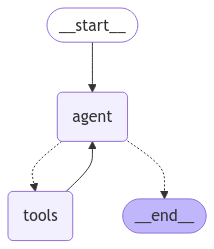

In [154]:
# Visualize the graph
try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [155]:
inputs = {
    "messages": [
        ("user", "How do I improve slow queries in MongoDB?"),
    ]
}

for output in app.stream(inputs):
    for key, value in output.items():
        print(f"Node {key}:")
        print(value)
print("---FINAL ANSWER---")
print(value["messages"][-1].content)

[HumanMessage(content='How do I improve slow queries in MongoDB?', additional_kwargs={}, response_metadata={}, id='d24196f2-dd7e-4342-9660-7f2a9933b807')]
Node agent:
{'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_8uC6x6EalTyPlaDn1xHG5bcr', 'function': {'arguments': '{"user_query":"How do I improve slow queries in MongoDB?"}', 'name': 'get_info_about_mongodb'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 27, 'prompt_tokens': 165, 'total_tokens': 192, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-11-20', 'system_fingerprint': 'fp_a523ccd45c', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-81181db3-2a33-479b-9ee6-f773c47c1275-0', tool_calls=[{'name': 'get_info_about_mongodb', 'args': {'user_query': 'How do 